# **簡易機器學習策略**

In [33]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
# 決策樹
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz 
# Linear Regression
from sklearn import linear_model
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# 混淆矩陣
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# ROC / AUC
from sklearn.metrics import roc_curve, auc


# 方法論
- 預測目標：預測一週後（五交易日後）收盤價相對今日收盤價是漲或跌
- 訓練模型：決策數\Linear Regression\Random Forest
- 價量資料與 4 種技術指標（macd、rsi、mom、stoch）

# 資料說明:
- 標的1：GOOG（日資料:2010-01-01 到 2024-03-31）
- 標第2 : S&P500 加權指數（日資料:2010-01-01 到 2024-03-31）




In [34]:
goog = yf.Ticker('GOOG')
sp500 = yf.Ticker('^SPX')
# 取得 2000 年至今的資料
data = goog.history(start = '2010-01-01',end='2024-03-31')
index = sp500.history(start = '2010-01-01',end='2024-03-31')
# 簡化資料，只取開、高、低、收以及成交量
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
index = index[['Open', 'High', 'Low', 'Close', 'Volume']]
# data = data.reset_index()
# data['Date'] = data['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

### Google 股票（GOOG）數據

In [35]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,15.615220,15.678981,15.547723,15.610239,78541293
2010-01-05 00:00:00-05:00,15.620949,15.637387,15.480475,15.541497,120638494
2010-01-06 00:00:00-05:00,15.588072,15.588072,15.102393,15.149715,159744526
2010-01-07 00:00:00-05:00,15.178109,15.193053,14.760922,14.797037,257533695
2010-01-08 00:00:00-05:00,14.744733,15.024933,14.672753,14.994298,189680313
...,...,...,...,...,...
2024-03-22 00:00:00-04:00,150.240005,152.559998,150.089996,151.770004,19226300
2024-03-25 00:00:00-04:00,150.949997,151.455994,148.800003,151.149994,15114700
2024-03-26 00:00:00-04:00,151.240005,153.199997,151.029999,151.699997,19312700


### S&P500 指數數據

In [36]:
index

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000
...,...,...,...,...,...
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000
2024-03-25 00:00:00-04:00,5219.520020,5229.089844,5216.089844,5218.189941,3331360000
2024-03-26 00:00:00-04:00,5228.850098,5235.160156,5203.419922,5203.580078,3871790000


In [37]:
data.columns = ['open','high','low','close','volume']
index.columns = ['open','high','low','close','volume']
# get features
ta_list = ['MACD','RSI','MOM','STOCH']
for x in ta_list:
    output = eval('abstract.'+x+'(data)')
    output.name = x.lower() if type(output) == pd.core.series.Series else None
    data = pd.merge(data, pd.DataFrame(output), left_on = data.index, right_on = output.index)
    index = pd.merge(index, pd.DataFrame(output), left_on = index.index, right_on = output.index)
    data = data.set_index('key_0')
    index = index.set_index('key_0')

### 將 macd、rsi、mom、stoch 作為因子加入數據

In [38]:
data

,open,high,low,close,volume,macd,macdsignal,macdhist,rsi,mom,slowk,slowd
key_0,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,15.615220,15.678981,15.547723,15.610239,78541293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05 00:00:00-05:00,15.620949,15.637387,15.480475,15.541497,120638494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06 00:00:00-05:00,15.588072,15.588072,15.102393,15.149715,159744526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07 00:00:00-05:00,15.178109,15.193053,14.760922,14.797037,257533695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08 00:00:00-05:00,14.744733,15.024933,14.672753,14.994298,189680313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,150.240005,152.559998,150.089996,151.770004,19226300,1.856500,0.199998,1.656501,65.157241,15.480011,72.451597,68.775166
2024-03-25 00:00:00-04:00,150.949997,151.455994,148.800003,151.149994,15114700,2.181649,0.596328,1.585321,63.717974,12.209991,73.163912,70.557630
2024-03-26 00:00:00-04:00,151.240005,153.199997,151.029999,151.699997,19312700,2.455408,0.968144,1.487264,64.467785,12.080002,75.966628,73.860712


In [39]:
index

,open,high,low,close,volume,macd,macdsignal,macdhist,rsi,mom,slowk,slowd
key_0,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000,1.856500,0.199998,1.656501,65.157241,15.480011,72.451597,68.775166
2024-03-25 00:00:00-04:00,5219.520020,5229.089844,5216.089844,5218.189941,3331360000,2.181649,0.596328,1.585321,63.717974,12.209991,73.163912,70.557630
2024-03-26 00:00:00-04:00,5228.850098,5235.160156,5203.419922,5203.580078,3871790000,2.455408,0.968144,1.487264,64.467785,12.080002,75.966628,73.860712


### 標記預測目標
漲：五交易日後的收盤價，比今日收盤價高 = 1

跌：五交易日後的收盤價，比今日收盤價低 = 0

In [40]:
data['week_trend'] = np.where(data.close.shift(-5) > data.close, 1, 0)
index['week_trend'] = np.where(index.close.shift(-5) > index.close, 1, 0)

### 展示2023年的圖例
- 紅色區塊 = 五日後 → 漲
- 綠色區塊 = 五日後 → 跌

/var/folders/n6/w2dqpywd7315xg1cv3m0q9zc0000gn/T/ipykernel_97696/463277741.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df = data['2023'].copy()
/var/folders/n6/w2dqpywd7315xg1cv3m0q9zc0000gn/T/ipykernel_97696/463277741.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot_date(t, y, 'b-', color = 'black')


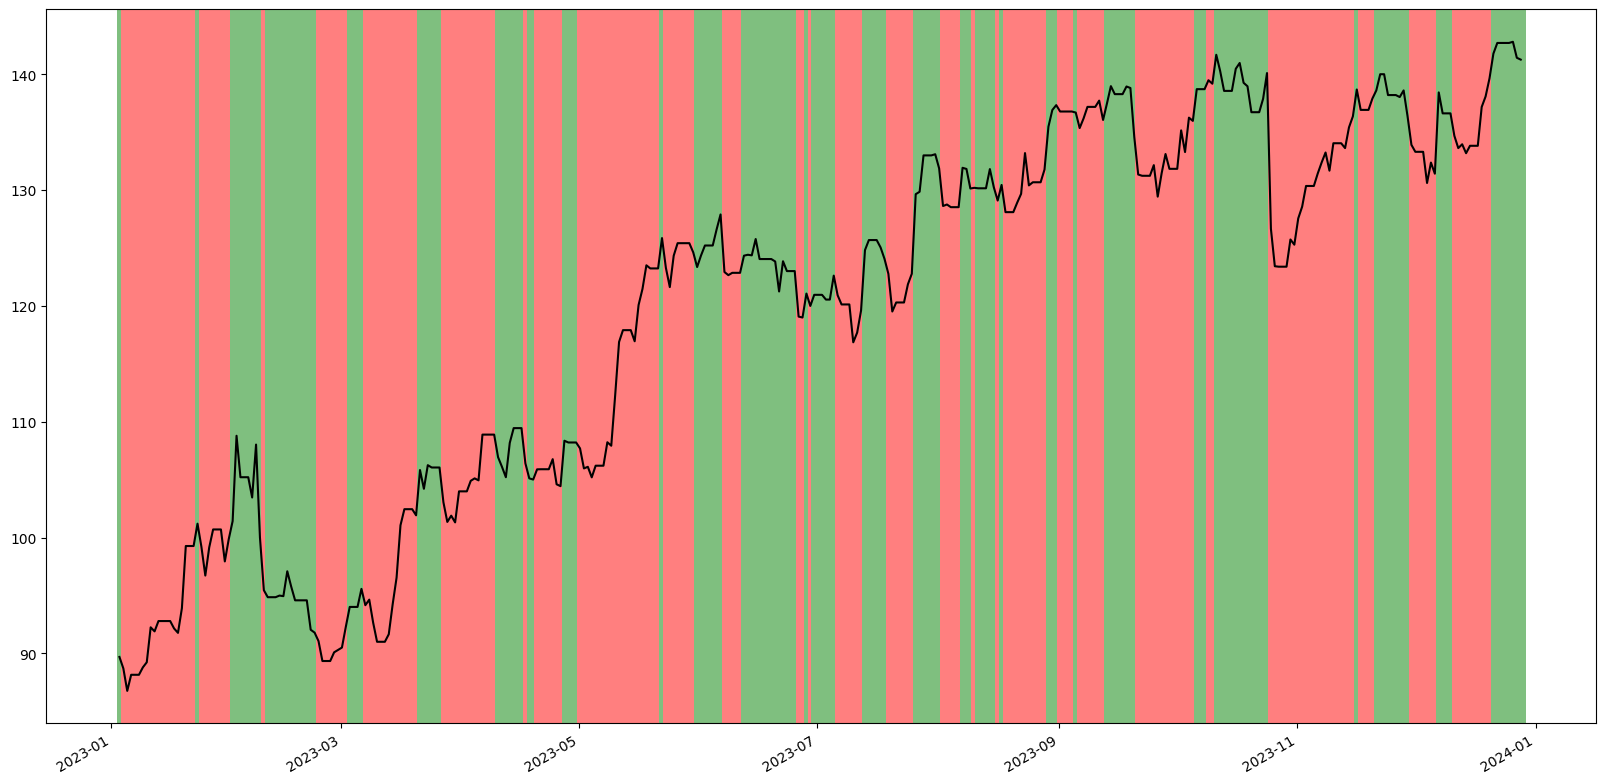

In [41]:
df = data['2023'].copy()
df = df.resample('D').ffill()
t = mdates.drange(df.index[0], df.index[-1], dt.timedelta(hours = 24))
y = np.array(df.close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color = 'black')
for i in range(len(df)):
    if df.week_trend[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'red', edgecolor = 'none', alpha = 0.5
            )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'green', edgecolor = 'none', alpha = 0.5
            )
fig.autofmt_xdate()
fig.set_size_inches(20, 10.5)
fig.savefig('define_y.png')

## 清理資料

In [42]:
# 檢查資料有無缺值
data.isnull().sum()
index.isnull().sum()
# 把有缺值的資料整列拿掉
data = data.dropna()
index = index.dropna()

# 實證分析
## 分割資料為訓練集及測試集
- 70% 訓練集
- 30% 測試集

In [43]:
split_point = int(len(data)*0.7)
train = data.iloc[:split_point,:].copy()
test = data.iloc[split_point:-5,:].copy()
train_index = index.iloc[:split_point,:].copy()
test_index = index.iloc[split_point:-5,:].copy()

In [44]:
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = train.drop('week_trend', axis = 1)
train_y = train.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = test.drop('week_trend', axis = 1)
test_y = test.week_trend

In [45]:
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X_index = train_index.drop('week_trend', axis = 1)
train_y_index = train_index.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X_index= test_index.drop('week_trend', axis = 1)
test_y_index = test_index.week_trend

### 依照不同模型進行訓練

#### **決策樹**

In [46]:
model_tree = DecisionTreeClassifier(max_depth = 10)
model_tree.fit(train_X, train_y)
prediction_tree = model_tree.predict(test_X)

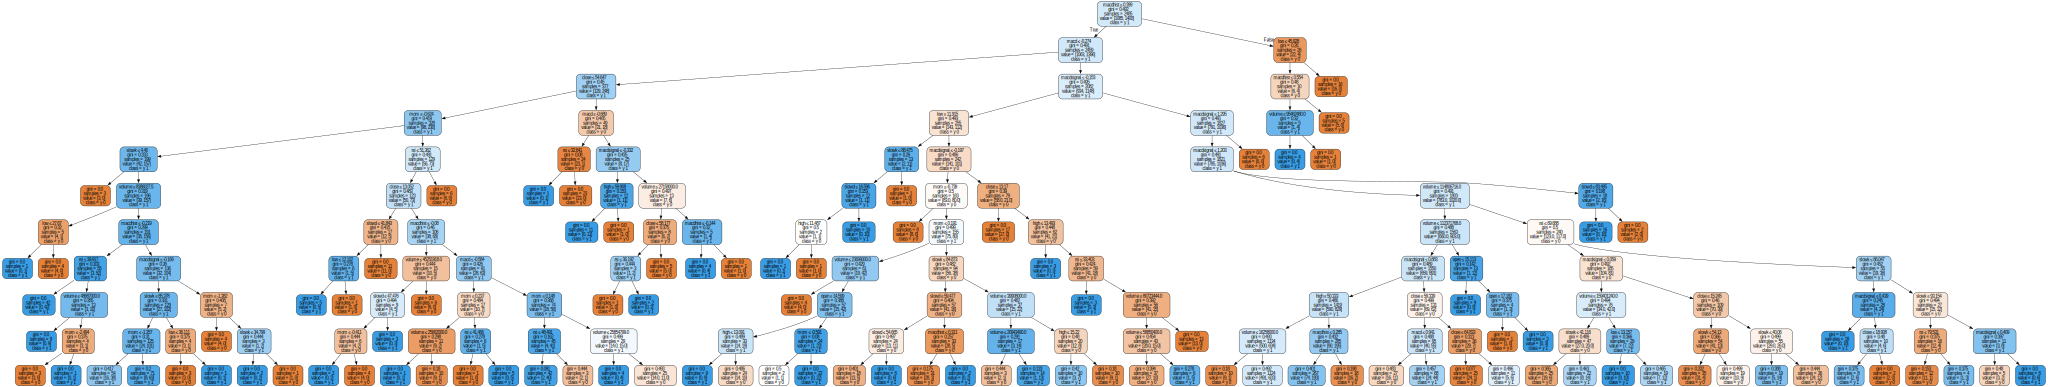

In [47]:
# DOT data
dot_data = export_graphviz(model_tree, out_file=None, 
                                feature_names = train_X.columns,
                                filled = True, rounded = True,
                                class_names = True,
                                special_characters = True)

# graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [48]:
# 準確率
print(f'Decesion Three 準確性(測試集):{model_tree.score(test_X, test_y)}')
print(f'Decesion Three 準確性(訓練集):{model_tree.score(train_X, train_y)}')

Decesion Three 準確性(測試集):0.4820754716981132
Decesion Three 準確性(訓練集):0.7018108651911469


#### **Linear Regression**

In [49]:
model_lr = linear_model.LinearRegression()
model_lr.fit(train_X,train_y)
prediction_lr = model_lr.predict(test_X)

In [50]:
print(f'linear regression 準確性：{model_lr.score(test_X, test_y)}')

linear regression 準確性：-0.27926635183360937


#### **Random Forest**

In [51]:
param_grid = {"max_depth":[4,5,6],
          "min_samples_leaf":[6,7,8],
          "min_samples_split":[7,8,9] }
forest_reg = RandomForestRegressor(n_estimators = 100)
grid = GridSearchCV(forest_reg, param_grid, cv=5)
grid.fit(train_X,train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'min_samples_leaf': [6, 7, 8],
                         'min_samples_split': [7, 8, 9]})

In [52]:
regressor = RandomForestRegressor(max_depth=5, min_samples_leaf=7, min_samples_split=8, n_estimators=100)
regressor.fit(train_X,train_y)
prediction_rf = regressor.predict(test_X)

In [53]:
print(f'Random Forest 準確性：{regressor.score(test_X, test_y)}')

Random Forest 準確性：-0.12694354168805533


In [54]:
def performance(Y_test, predict):
  mse = np.mean((Y_test-predict)**2)
  rmse = np.sqrt(np.mean((Y_test-predict)**2))
  mae = np.mean(np.abs(Y_test-predict))
  mape = np.mean((np.abs(Y_test-predict))/Y_test) * 100

  return mse, rmse, mae, mape

In [55]:
tree=performance(test_y, prediction_tree)
lr=performance(test_y, prediction_lr)
rf=performance(test_y, prediction_rf)

In [56]:
import prettytable as pt

tb1 = pt.PrettyTable()
tb1.field_names = ['Model', 'MSE', 'RMSE', 'MAE', 'MAPE']
tb1.add_row(['Decision Trees',tree[0],tree[1],tree[2],tree[3]])
tb1.add_row(['Linear Regression',lr[0],lr[1],lr[2],lr[3]])
tb1.add_row(['Random Forest',rf[0],rf[1],rf[2],rf[3]])
print(tb1)

+-------------------+---------------------+--------------------+--------------------+------+
|       Model       |         MSE         |        RMSE        |        MAE         | MAPE |
+-------------------+---------------------+--------------------+--------------------+------+
|   Decision Trees  |  0.5179245283018868 | 0.7196697355745112 | 0.5179245283018868 | inf  |
| Linear Regression |  0.3137492949814344 | 0.5601332832294778 | 0.5002352924316702 | inf  |
|   Random Forest   | 0.27639102770249124 | 0.5257290439974677 | 0.5008955304502299 | inf  |
+-------------------+---------------------+--------------------+--------------------+------+


-  mean squared error (MSE): 可以用來判斷數據變化程度，只考慮誤差大小，不考慮其方向。
-  root-mean-square error (RMSE):資料在最佳預測線附近的集中情況。
-  mean absolute error (MAE): 觀測值與實際值的誤差的絕對值的平均值。
#### 依照上圖顯示，Random Forest 的誤差皆為較小，但RMSE最高的為Decession Three 因此將嘗試用Decision Tree去預估並進行回測。

### 混淆矩陣

In [57]:
# 混淆矩陣
cm = confusion_matrix(test_y, prediction_tree)
cm

array([[380,  77],
       [472, 131]])

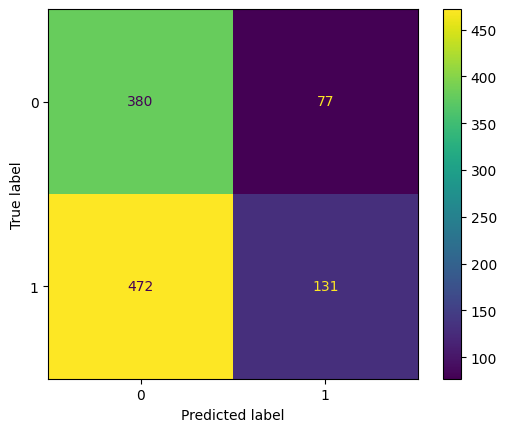

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model_tree.classes_)
disp.plot()

### 所以可以用上圖計算預測準確度為：0.4811320754716981

## ROC / AUC

In [59]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction_tree)

# 計算 AUC 面積
print(f'AUC = {auc(false_positive_rate, true_positive_rate)}')

AUC = 0.5243784723356231


#### AUC 0.522 > 0.5 還算不錯。

## 策略回測
策略：
- T-1 日的預測為「跌」而 T 日的預測為「漲」，則 T+1 日開盤「買進」
- T-1 日的預測為「漲」而 T 日的預測為「跌」，則 T+1 日開盤「賣出」
- 連續預測「漲」，則「持續持有」
- 連續預測「跌」，則「空手等待」

總交易次數：43
勝率：55.81395348837209%
獲利因子：1.7698659786921842
平均淨報酬率：1.1101492407026092%
累積報酬率：52.5441911974885%


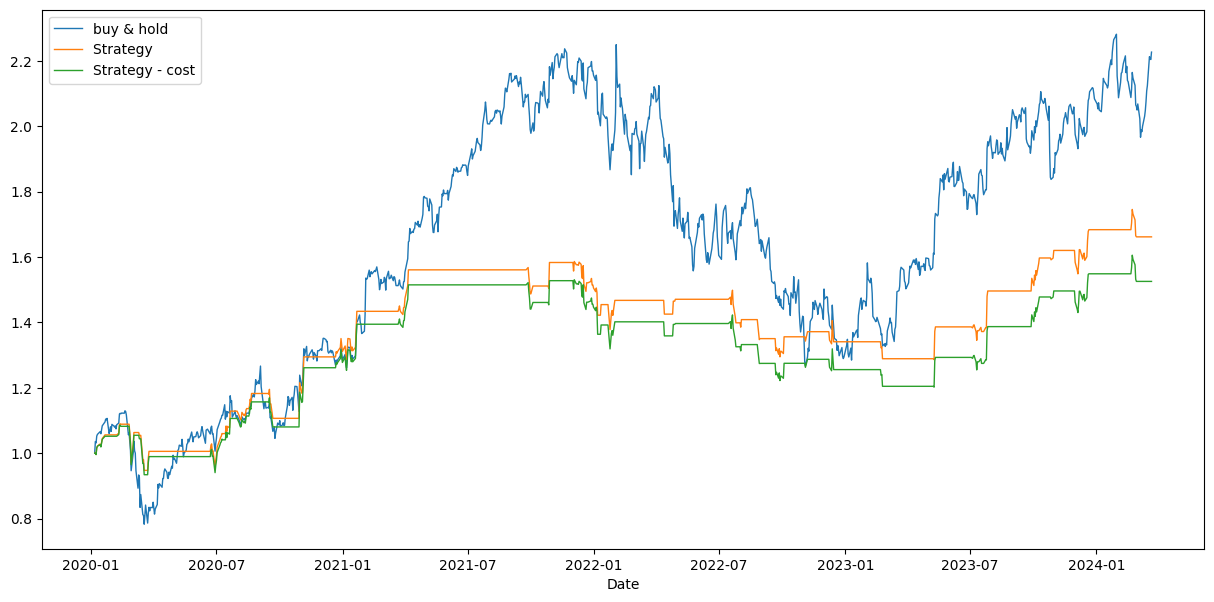

In [60]:
test['prediction_tree'] = prediction_tree

test['status'] = test.prediction_tree.shift(1).fillna(0)

test['buy_cost'] = test.open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
test['sell_cost'] = test.open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]
test = test.fillna(0)


buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])


if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1

fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.open / test.open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

# 績效走勢圖
test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

trade_count = len(sell_dates)
trade_count_per_year = trade_count / (len(test)/252)
win_rate = (net_trade_return > 0).sum() / trade_count
profit_factor = net_trade_return[net_trade_return > 0].sum() / abs(net_trade_return[net_trade_return < 0].sum())
mean_net_return = np.mean(net_trade_return)
acc_ret = test.strategy_net_equity[-1] - 1
strategy_ear = test.strategy_net_equity[-1] ** (252/len(test)) - 1
strategy_std = test.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std

print(f'總交易次數：{trade_count}')
print(f'勝率：{win_rate*100}%')
print(f'獲利因子：{profit_factor}')
print(f'平均淨報酬率：{mean_net_return*100}%')
print(f'累積報酬率：{acc_ret*100}%')

plt.figure(figsize=(15,7))
plt.xlabel('Date')
plt.plot(test['buy_and_hold_equity'],label='buy & hold',linewidth=1)
plt.plot(test['strategy_equity'],label='Strategy ',linewidth=1)
plt.plot(test['strategy_net_equity'],label = 'Strategy - cost',linewidth=1)
plt.legend()

In [61]:
model_tree_index = DecisionTreeClassifier(max_depth = 10)
model_tree_index.fit(train_X_index, train_y_index)
prediction_tree_index = model_tree_index.predict(test_X_index)
print(f'Decesion Three 準確性:{model_tree.score(test_X_index, test_y_index)}')

Decesion Three 準確性:0.4509433962264151


總交易次數：24
勝率：41.66666666666667%
獲利因子：1.406539314660647
平均淨報酬率：1.2823764877236155%
累積報酬率：26.52160447604517%


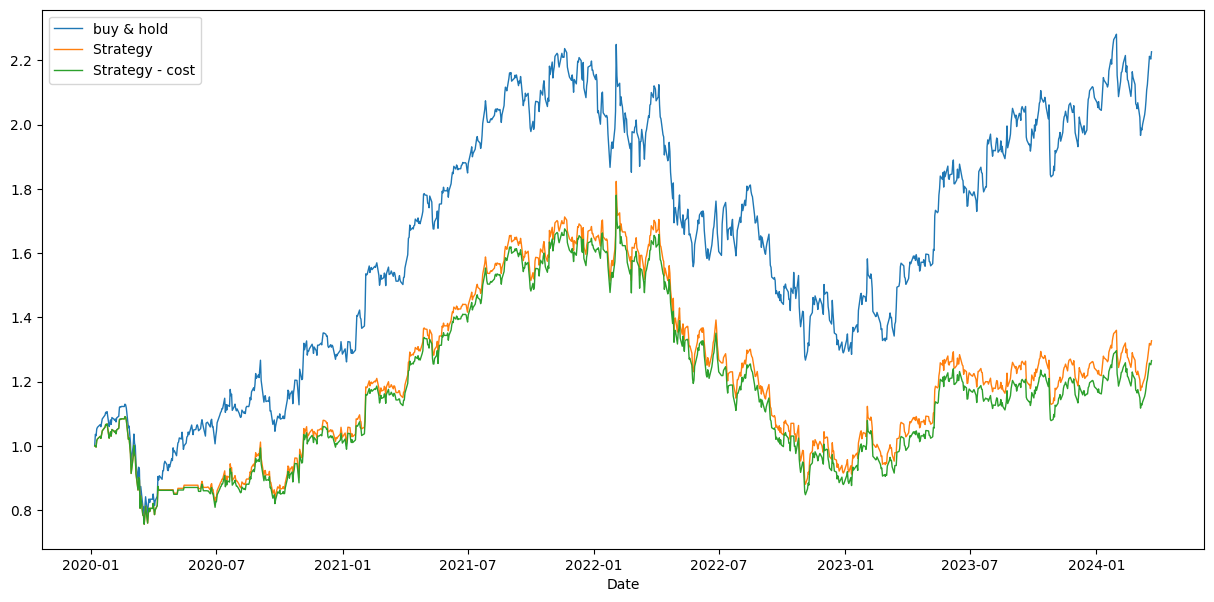

In [62]:
test['prediction_tree'] = prediction_tree_index

# 直接把 prediction_svr 位移一天，剛好就會是模擬買賣的狀況：
test['status'] = test.prediction_tree.shift(1).fillna(0)


test['buy_cost'] = test.open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
test['sell_cost'] = test.open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]
test = test.fillna(0)


buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])


if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1

fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.open / test.open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

# 績效走勢圖
test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

trade_count = len(sell_dates)
trade_count_per_year = trade_count / (len(test)/252)
win_rate = (net_trade_return > 0).sum() / trade_count
profit_factor = net_trade_return[net_trade_return > 0].sum() / abs(net_trade_return[net_trade_return < 0].sum())
mean_net_return = np.mean(net_trade_return)
acc_ret = test.strategy_net_equity[-1] - 1
strategy_ear = test.strategy_net_equity[-1] ** (252/len(test)) - 1
strategy_std = test.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std

print(f'總交易次數：{trade_count}')
print(f'勝率：{win_rate*100}%')
print(f'獲利因子：{profit_factor}')
print(f'平均淨報酬率：{mean_net_return*100}%')
print(f'累積報酬率：{acc_ret*100}%')

plt.figure(figsize=(15,7))
plt.xlabel('Date')
plt.plot(test['buy_and_hold_equity'],label='buy & hold',linewidth=1)
plt.plot(test['strategy_equity'],label='Strategy ',linewidth=1)
plt.plot(test['strategy_net_equity'],label = 'Strategy - cost',linewidth=1)
plt.legend()

### 技術指標對於漲跌預測的成效

In [63]:
#檢查相關性
data.pct_change().dropna().corr()

,open,high,low,close,volume,macd,macdsignal,macdhist,rsi,mom,slowk,slowd,week_trend
open,1.000000,0.766833,0.746308,0.427206,0.043661,0.073163,-0.041571,0.028918,0.283197,-0.035448,0.181525,0.280342,-0.082817
high,0.766833,1.000000,0.797663,0.766310,0.166762,0.091091,-0.012190,0.030705,0.616486,-0.027914,0.290937,0.266764,-0.180261
low,0.746308,0.797663,1.000000,0.751907,-0.131439,0.085299,-0.005042,0.009422,0.628484,-0.020828,0.270314,0.277129,-0.143572
close,0.427206,0.766310,0.751907,1.000000,0.005414,0.084513,0.011838,0.010428,0.881332,-0.009284,0.368320,0.206808,-0.248228
volume,0.043661,0.166762,-0.131439,0.005414,1.000000,-0.009387,0.018266,0.001256,-0.067834,0.021414,-0.017000,-0.022379,-0.048214
macd,0.073163,0.091091,0.085299,0.084513,-0.009387,1.000000,0.001690,0.004724,0.047560,0.000601,0.005235,0.031440,0.023242
macdsignal,-0.041571,-0.012190,-0.005042,0.011838,0.018266,0.001690,1.000000,0.000510,0.007983,0.000893,-0.008702,-0.016879,0.010886
macdhist,0.028918,0.030705,0.009422,0.010428,0.001256,0.004724,0.000510,1.000000,0.008043,0.000989,0.023978,0.034073,-0.020001
rsi,0.283197,0.616486,0.628484,0.881332,-0.067834,0.047560,0.007983,0.008043,1.000000,-0.014660,0.462792,0.250779,-0.238655
mom,-0.035448,-0.027914,-0.020828,-0.009284,0.021414,0.000601,0.000893,0.000989,-0.014660,1.000000,-0.034723,0.004767,-0.004852


<BarContainer object of 12 artists>

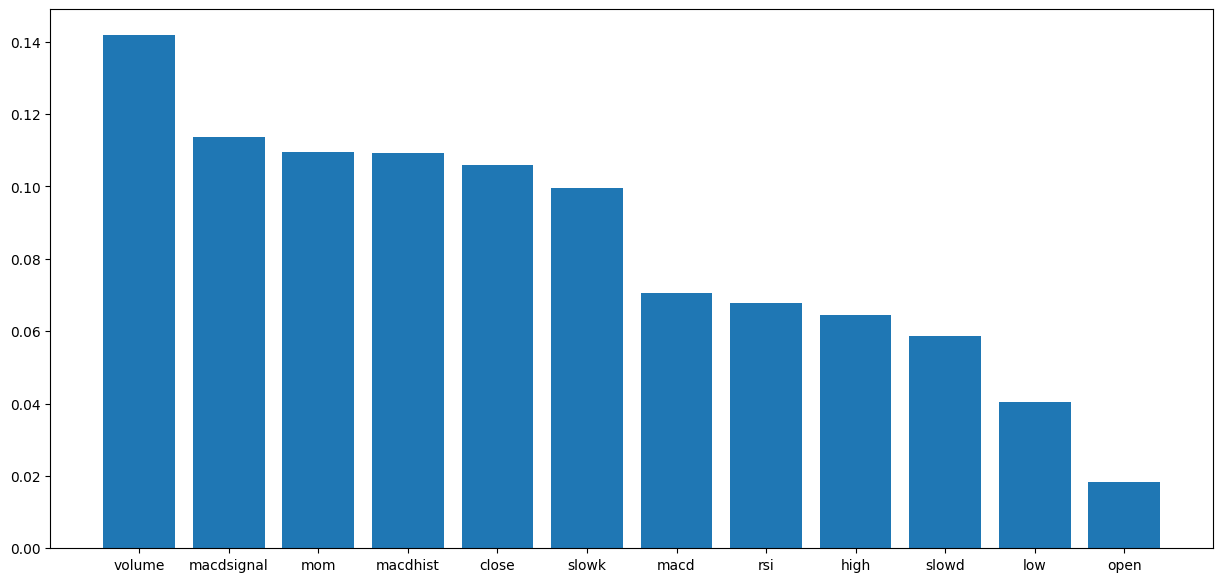

In [65]:
feature_importances = model_tree.feature_importances_

# 將 feature 進行排序
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = list(data.columns[sorted_indices])
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(15,7))
plt.bar(sorted_feature_names,sorted_importances)

# 結論:
由上述可以知道，此次決策樹影響預測績效的因子 Volume 佔最大比例，接著是macd、mom，而最後的是open。

我們發展一個預測 5 日後漲跌的決策樹預測模型，最大的目的是希望 能夠有效偵測買點且規避風險，提供優良的進出場建議。但從結果來看，這次結果並不良好。
可能是macd這項指標不夠並不適合。

股票：GOOG
- 總交易次數：43
- 勝率：55.81395348837209%
- 獲利因子：1.7698659786921842
- 平均淨報酬率：1.1101492407026092%
- 累積報酬率：52.5441911974885%

大盤：S&P500 index

- 總交易次數：24
- 勝率：41.66666666666667%
- 獲利因子：1.406539314660647
- 平均淨報酬率：1.2823764877236155%
- 累積報酬率：26.52160447604517%

雖然勝率有到55％，但相較於Buy&Hold的績效表現較差，但相較於大盤較好。因此針對這次結果，做出幾個改善：

- 更換機器學習模型，像是LSTM、CNN等
- 將預測時距縮短，改成1天或是1天內。
